In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import copy

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Shashank')

In [5]:
# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io

# # My Modules
import helpers as helpers
import model_systems as model_systems
import diffusion_map as dmap

# Compute reference potential and density on grid

grid maximum is: 0


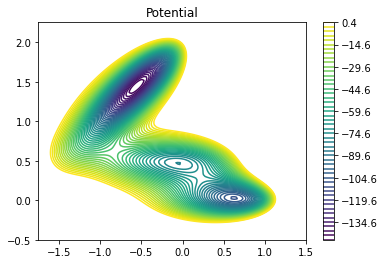

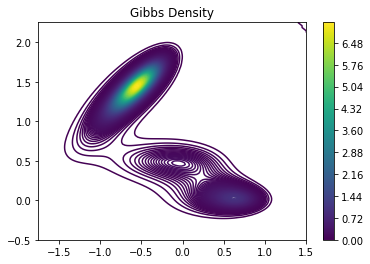

In [ ]:
helpers.plot_density()

In [ ]:
scipy.integrate.dblquad(lambda x,y: helpers.density([x,y]), -10, 10, lambda x: -10, lambda x: 10)

(0.999999999999642, 2.0442218235764304e-08)

# Load Trajectory Data

number of data points: 9987


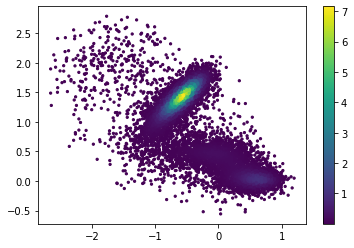

In [7]:
dataset = 'FEM20_data30'
fname = f"Muller_Data_{dataset}.npz"

# # Load metadynamics 
# inData = scipy.io.loadmat("Muller_Data_Metadynamics_20.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
# data = inData['pts']
# data = data.T
# inData = scipy.io.loadmat("Muller_Data_FEM20_data20_metadynamics.mat")
# qFEM = inData['interpolant'].flatten()
# data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
# qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


# # Load uniform 
# inData = scipy.io.loadmat("Muller_Data_Uniform.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
# data = inData['pts']
# data = data.T
# inData = scipy.io.loadmat("Muller_Data_FEM20_uniform.mat")
# qFEM = inData['interpolant'].flatten()
# data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
# qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


# Load boltzmann trajectory: for uniform data use value 'pts' 
inData = scipy.io.loadmat("Muller_trajectory_beta_inv_30.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
data = inData['traj']
data = data.T

# FEM Committor Data
inData = scipy.io.loadmat("Muller_Data_FEM20_T_30.mat")
qFEM = inData['interpolant'].flatten()
data = np.delete(data, np.where(np.isnan(qFEM)), axis = 1) 
qFEM = np.delete(qFEM, np.where(np.isnan(qFEM))) # delete the points where qFEM is nan 


N = data.shape[1]
print("number of data points: %d" % N)

# Compute gibbs density of each data point
density_traj = np.zeros(N)
for i in range(N):
    density_traj[i] = helpers.density(data[:, i])

plt.scatter(data[0, :], data[1, :], s=5.0, c=density_traj)
plt.colorbar()


# Throwing away points module 

In [8]:
boolz = helpers.throwing_pts_muller(data, 0)
error_bool = boolz['error_bool']
throwing_bool = boolz['throwing_bool']
A_bool = boolz['A_bool']
B_bool = boolz['B_bool']
C_bool = boolz['C_bool']

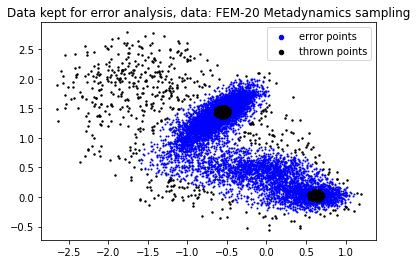

In [9]:
# # Define what points to keep and not for error
# error_bool = np.logical_not(outliers)

# # Throw away A,B points from 'error' set
# error_bool_AB = np.logical_not(np.logical_or(A_bool, B_bool)) 
# error_bool = np.logical_and(error_bool, error_bool_AB)

# throwing_bool = np.logical_not(error_bool)

plt.figure()
throw_color = 'k'
keep_color = 'b'
plt.scatter(data[0, error_bool], data[1, error_bool], s=1.0, c=keep_color)
plt.scatter(data[0, throwing_bool], data[1, throwing_bool], s=2.0, c=throw_color)
#plt.title(f"Data kept for error analysis, data:{dataset}")
plt.title(f"Data kept for error analysis, data: FEM-20 Metadynamics sampling")
lgnd = plt.legend(['error points', 'thrown points'])
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])

# Define some masks for the contours so the contour plots are prettier
contour_bdry = -10
contour_bool = np.ones(N, dtype=bool)
for n in range(N):
    if model_systems.muller_potential(data[:, n]) > contour_bdry:
        contour_bool[n] = False
triang = tri.Triangulation(data[0, :], data[1, :])
triangle_mask = np.any(np.logical_not(contour_bool)[triang.triangles], axis=1)
triang.set_mask(triangle_mask)

# Define A,B for Committor

Text(0, 0.5, '$x_2$')

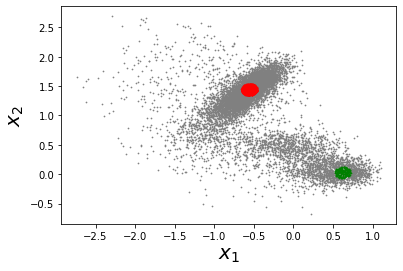

In [ ]:
centerx_A, centery_A, rad_A = [-0.558, 1.441, 0.1]
centerx_B, centery_B, rad_B = [0.623, 0.028, 0.1]
A_bool, B_bool, C_bool = helpers.is_in_ABC(data, centerx_A, centery_A, rad_A, 
                                         centerx_B, centery_B, rad_B)
A_test = data[:, A_bool]
B_test= data[:, B_bool]
C_test = data[:, C_bool]
transition_bool = np.logical_not(np.logical_or(A_bool, B_bool)) 

fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.5, c='gray')
plt.scatter(A_test[0, :], A_test[1, :], s=0.5, c='r')
plt.scatter(B_test[0, :], B_test[1, :], s=0.5, c='g')
#plt.scatter(C_test[0, :], C_test[1, :], s=0.5, c='b')
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)


## Define masks for the contour plots so the contour plots are prettier

In [ ]:
contour_bdry = -20  # !! tunable theshold
contour_bool = np.ones(N, dtype=bool)
for n in range(N):
    if model_systems.muller_potential(data[:, n]) > contour_bdry:
        contour_bool[n] = False
triang = tri.Triangulation(data[0, :], data[1, :])
triangle_mask = np.any(np.logical_not(contour_bool)[triang.triangles], axis=1)
triang.set_mask(triangle_mask)

#^ how the triangulation is used for plotting is shown in cells below

## Interpolate FEM committor to data, plot contours

(9993,)


Text(0.5, 1.0, 'Interpolated FEM solution, committor contours, data:FEM20_data30')

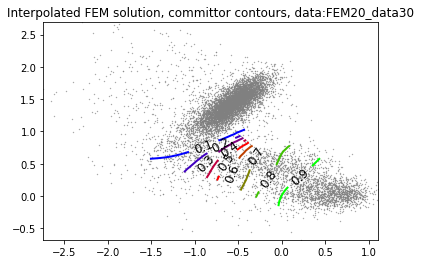

In [ ]:
# look up this function for interpolation: 
# griddata on matlab! 

plt.figure()
plt.scatter(data[0, :], data[1, :], s=0.1, c='gray')
my_levels = helpers.committor_contours()
cmap = 'brg'
print(triang)
print(qFEM.shape)
C=plt.tricontour(triang, qFEM, levels=my_levels, linewidths=2.0, cmap=cmap)
plt.clabel(C, C.levels, fmt = '%0.1f', colors = 'k', fontsize=12) #contour line labels
plt.title(f'Interpolated FEM solution, committor contours, data:{dataset}') 


## Compute Error for TMDMAP against FEM for range of epsilon values

In [110]:
# Prep for scanning over bandwidth, net resolution, vbdry values, and delta net 
# resolutions

eps_vals = 2.0**np.arange(-10, -8, 0.5)
delta_vals = np.linspace(1e-5, 1e-1, 2)
knn_vals = 2**np.arange(6,8,1)
vbdry_vals = np.arange(-50,-30, 10)
num_idx = eps_vals.shape[0]
num_delta = delta_vals.shape[0]
num_knn = knn_vals.shape[0]
num_vbdry = vbdry_vals.shape[0]
error_data_TMD_FEM = np.zeros((num_idx, num_delta, num_knn, num_vbdry))
error_data_FEM_TMD = np.zeros((num_idx, num_delta, num_knn, num_vbdry))
errors = np.zeros((num_idx, num_delta))
errors1d = np.zeros(num_idx)
# err_boolz = helpers.throwing_pts_muller(data, 0)
# error_bool = err_boolz['error_bool']
# A_bool = err_boolz['A_bool']
# B_bool = err_boolz['B_bool']
# C_bool = err_boolz['C_bool']

In [116]:
from math import nan
from joblib import Parallel, delayed
import multiprocessing
import itertools
# what are your inputs, and what operation do you want to
# perform on each input. For example...
zz = np.zeros((3,3))
def processInput(i):
    zz[i[0],i[1]] = i[0]*i[1]
delayeds = [delayed(processInput)(i) for i in itertools.product(range(3),range(3))]
parallels = Parallel(n_jobs=2, require='sharedmem')
parallels(delayeds)

[None, None, None, None, None, None, None, None, None]

In [114]:

# for j in range(1,num_delta):
#     print("Current net resolution: ", delta_vals[j])

#     #Prepare for this round of resolution 
#     ϵ_net = helpers.epsilon_net(data, delta_vals[j])[0]
#     N = np.size(ϵ_net)

for i in range(num_idx):
  for j in range(num_delta):
    for k in range(num_knn):
      for l in range(num_vbdry):
            eps = eps_vals[i] # Current epsilon 
            delta = delta_vals[j] # Current delta net resolution 
            n_neigh = knn_vals[k] # Current knn values 
            vbdry = vbdry_vals[l] # Current vbdry term
            ϵ_net = helpers.epsilon_net(data, delta)[0] # set up \delta net
            N = np.size(ϵ_net) # number of points in net
            err_boolz = helpers.throwing_pts_muller(data, vbdry) # set up error points based on vbdry 
            error_bool = err_boolz['error_bool']
            A_bool = err_boolz['A_bool']
            B_bool = err_boolz['B_bool']
            C_bool = err_boolz['C_bool']
            data_current = data[:, ϵ_net] # solve TMD for points in 
            A_bool_current = A_bool[ϵ_net]
            B_bool_current = B_bool[ϵ_net]
            C_bool_current = C_bool[ϵ_net]
            error_bool_current = error_bool[ϵ_net]
            q_FEM_current = qFEM[ϵ_net]

            # Set KNN number of neighbors
            #n_neigh = knn
            #print(f"KNN num neighbors: {n_neigh}") 

            # Compute target measure 
            def V(x): return model_systems.muller_potential(x)
            target_measure = np.zeros(N)

            #!!!!!! define target density here, by default its to a different temperature of gibbs
            target_beta = 1/20.  
            for m in range(N):
                    target_measure[m] = np.exp(-target_beta*V(data_current[:, m]))/helpers.Z

            #for i in range(0, num_idx):
            #eps = eps_vals[i]

            ##### Compute some sort of diffusion map 
            target_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps,
                                                      n_neigh=n_neigh, target_measure=target_measure);

            # Can use regular diffusion map if the 'target measure' is the same as the gibbs density the data came from
            #reg_dmap = dmap.DiffusionMap(epsilon=eps, alpha=0.5,
            #                                          n_neigh=n_neigh, target_measure=target_measure)

            target_dmap.construct_generator(data_current)
            K = target_dmap.get_kernel()
            L = target_dmap.get_generator()
            q = target_dmap.construct_committor(L, B_bool_current, C_bool_current);
            # print ("\033[A                             \033[A")
            ###############################################################################
            # Compute Error
            ###############################################################################
            qFEM_restr = q_FEM_current[error_bool_current]
            q_restr = q[error_bool_current]
            error_data_TMD_FEM[i,j,k,l] = helpers.RMSerror(q_restr,qFEM_restr)
            print(error_data_TMD_FEM[i,j,k,l])
            #qFEM_restr = qFEM 
            #q_restr = q
            # qFEM_restr = q_FEM_current 
            # q_restr = q
            #errors1d[i] = helpers.RMSerror(q_restr, qFEM_restr)
            #errors[i,j] = helpers.RMSerror(q_restr, qFEM_restr); 
            #print("epsilon = %f", eps)
            #print(errors1d[i])
            #print("\r",end="")
            #print(errors[i,j])


0.006654794026121397
0.0075355258775034045
0.01056230656667823
0.011629115831170149
0.03619282651182239
0.042783563342523465
0.03619282651041125
0.0427835633415129
0.0032850648682254302
0.003470322092972313
0.0056261365224190545
0.006370496213749897
0.021379468427183253
0.02934614785150632
0.021379468427263463
0.02934614785155241
0.006422161373942103
0.006585624425368849
0.0032349549208581835
0.0036488871419062935
0.014217282280074479
0.01986779430351299
0.014217282280067696
0.019867794303510548
0.008832504413521205
0.009177084211567064
0.0053444421185328455
0.005503012016330711
0.009249723761571788
0.011726265377589522
0.009249723761571049
0.011726265377589296


In [ ]:
## saving error data
np.savetxt("errors_net_gibbs_0.05_thisoneworks", errors1d, delimiter=",")
# np.savetxt("errors_boltzmann_0.05_64", errors1d, delimiter=",")

In [5]:
errs = np.genfromtxt("errors_net_gibbs_0.05_thisoneworks", delimiter=",")

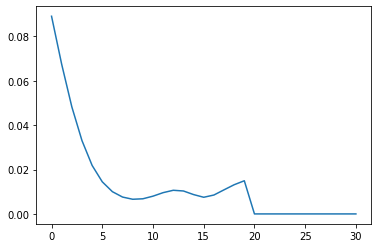

In [9]:
plt.plot(errs[3:])

In [10]:
errs

array([           nan, 7.07560674e+11, 8.82202186e+03, 8.91098860e-02,
       6.74468704e-02, 4.82588199e-02, 3.30468345e-02, 2.18552352e-02,
       1.44712378e-02, 1.00180309e-02, 7.59672781e-03, 6.60662405e-03,
       6.81974779e-03, 8.00338639e-03, 9.58882168e-03, 1.06570383e-02,
       1.03391263e-02, 8.71744455e-03, 7.50455970e-03, 8.51036245e-03,
       1.08532529e-02, 1.31545055e-02, 1.49472354e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

## Plot error data here! 

In [ ]:
errors_unif = np.genfromtxt("errors_net_uniform", delimiter=",")
#errors1d_unif = np.genfromtxt("errors_boltzmann_0.05_uniform", delimiter=",")

In [ ]:
errors_meta = np.genfromtxt("errors_net_metadynamics", delimiter=",")
errors1d_meta = np.genfromtxt("errors_boltzmann_0.05_metadynamics", delimiter=",")

In [ ]:
errors = np.genfromtxt("errors_net", delimiter=",")
errors1d = np.genfromtxt("errors_boltzmann_0.05", delimiter=",")

In [ ]:
colors = iter(plt.cm.rainbow(np.linspace(0,1,num_delta)))
plt.figure()
plt.xscale("log")
for i in range(4,num_delta):
    plt.plot(eps_vals[5:], errors_meta[5:32, i], 
             marker = 'o',
             color = next(colors),
             label = str(round(delta_vals[i],5)))


plt.plot(eps_vals[5:], errors1d_meta[5:32], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[5:], errors1d[5:32], marker = 'o', color='black', label = "Boltzmann")
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
#plt.ylim((0,0.02))
plt.title("Errors analysis for TMD maps for delta-nets on metadynamics densities when beta = 1/20")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
colors = iter(plt.cm.rainbow(np.linspace(0,1,num_delta)))
plt.figure()
plt.xscale("log")
for i in range(4,num_delta):
    plt.plot(eps_vals[10:16], errors_meta[10:16, i], 
             marker = 'o',
             color = next(colors),
             label = str(round(delta_vals[i],5)))


plt.plot(eps_vals[10:16], errors1d_meta[10:16], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[10:16], errors1d[10:16], marker = 'o', color='black', label = "Boltzmann")
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
plt.ylim((0,0.02))
plt.title("Errors analysis for TMD maps for delta-nets on metadynamics densities when beta = 1/20")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
colors = iter(plt.cm.rainbow(np.linspace(0,1,num_delta)))
plt.figure()
plt.xscale("log")
for i in range(0,3):
    plt.plot(eps_vals[2:], errors_unif[2:, i], 
             marker = 'o',
             color = next(colors),
             label = str(round(delta_vals[i],5)))


plt.plot(eps_vals[2:], errors1d_unif[2:], marker = 'o', color='red', label = "Uniform")
#plt.plot(eps_vals[10:16], errors1d[10:16], marker = 'o', color='black', label = "Boltzmann")
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
#plt.ylim((0,0.02))
plt.title("Errors analysis for TMD maps for Uniform densities when beta = 1/20")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
plt.figure()
plt.xscale("log")
#plt.plot(eps_vals[5:], errors1d_meta[5:], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[7:], errors1d[7:], marker = 'o', color='black', label = "Boltzmann")


In [ ]:
colors = iter(plt.cm.rainbow(np.linspace(0,1,num_delta)))
plt.figure()
plt.xscale("log")
for i in range(4,num_delta):
    plt.plot(eps_vals[5:], errors_unif[5:, i], 
             marker = 'o',
             color = next(colors),
             label = str(round(delta_vals[i],5)))


plt.plot(eps_vals[5:], errors1d_meta[5:32], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[5:], errors1d[5:32], marker = 'o', color='black', label = "Boltzmann")
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
#plt.ylim((0,0.02))
plt.title("Errors analysis for TMD maps for Boltzmann vs Uniform densities when beta = 1/20")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


In [ ]:
colors = iter(plt.cm.rainbow(np.linspace(0,1,num_delta)))
plt.figure()
plt.xscale("log")
for i in range(4,num_delta):
    plt.plot(eps_vals[7:16], errors_unif[7:16, i], 
             marker = 'o',
             color = next(colors),
             label = str(round(delta_vals[i],5)))


plt.plot(eps_vals[7:16], errors1d_meta[7:16], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[7:16], errors1d[7:16], marker = 'o', color='black', label = "Boltzmann")
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
plt.ylim((0,0.02))
plt.title("Errors analysis for TMD maps on Uniform densities when beta = 1/20")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


# Interpolate TMD-solutions to FEM data

In [120]:
# get FEM underlying data

fem_Data = scipy.io.loadmat("DistmeshMueller_20.mat")
fem_grid = fem_Data['pts']
fem_committor = fem_Data['committor']

In [ ]:
# get FEM underlying data

fem_Data = scipy.io.loadmat("DistmeshMueller_20.mat")
fem_grid = fem_Data['pts']
fem_committor = fem_Data['committor']
#data = data.T

# throwing points 
err_fem = helpers.throwing_pts_muller(fem_grid.T, -40)[0]
error_bool = helpers.throwing_pts_muller(data, -40)[0]
fem_committor = fem_committor[err_fem,:] # comment this out if you don't want error data over thrown points

# prepare for pass over data
eps_vals = 10.0**np.arange(-14, 4, 0.5)
delta_vals = np.linspace(1e-5, 1e-1, 15)
num_idx = eps_vals.shape[0]
num_delta = delta_vals.shape[0]
errors = np.zeros((num_idx, num_delta))
errors1d = np.zeros(num_idx)

In [ ]:
# get tmdsolution to metadynamics problem 

ϵ_net = range(0,N)
np.size(ϵ_net)
data_current = data[:, ϵ_net]
A_bool_current = A_bool[ϵ_net]
B_bool_current = B_bool[ϵ_net]
C_bool_current = C_bool[ϵ_net]
error_bool_current = error_bool[ϵ_net]
#q_FEM_current = qFEM[ϵ_net]

# Compute target measure 
def V(x): return model_systems.muller_potential(x)
target_measure = np.zeros(N)

#!!!!!! define target density here, by default its to a different temperature of gibbs
target_beta = 1/20.  
for i in range(N):
        target_measure[i] = np.exp(-target_beta*V(data_current[:, i]))
for i in range(num_idx):

  n_neigh = 128
  eps = eps_vals[i]
  ##### Compute some sort of diffusion map 
  target_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps,
                                            n_neigh=n_neigh, target_measure=target_measure);

  # Can use regular diffusion map if the 'target measure' is the same as the gibbs density the data came from
  #reg_dmap = dmap.DiffusionMap(epsilon=eps, alpha=0.5,
  #                                          n_neigh=n_neigh, target_measure=target_measure)

  target_dmap.construct_generator(data_current)
  #target_dmap.construct_generator(data[:,ϵ_net]) # tmdmap for epsilon net
  K = target_dmap.get_kernel()
  L = target_dmap.get_generator()
  q = target_dmap.construct_committor(L, B_bool_current, C_bool_current);
  # print ("\033[A                             \033[A")
  ###############################################################################
  # Compute Error
  ###############################################################################
  # qFEM_restr = q_FEM_current[error_bool_current]
  # q_restr = q[error_bool_current]
  rev_interpolant = scipy.interpolate.griddata(data_current.T, q, fem_grid, method='linear')[err_fem]
  rev_interpolant_refined = np.delete(rev_interpolant, np.where(np.isnan(rev_interpolant)))
  fem_interpolant_refined = np.delete(fem_committor, np.where(np.isnan(rev_interpolant)))
  if (rev_interpolant_refined.shape[0] != 0):
        errors1d[i] = helpers.RMSerror(rev_interpolant_refined, fem_interpolant_refined)
  print(errors1d[i])
# qFEM_restr = qFEM 
# q_restr = q

In [ ]:
# errors_metad = copy.deepcopy(errors1d)
# errors_boltzmann = copy.deepcopy(errors1d)
# errors_uniform = copy.deepcopy(errors1d)

In [ ]:
plt.figure()
plt.xscale('log')
plt.plot(eps_vals[6:], errors_metad[6:32], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[6:], errors_boltzmann[6:32], marker = 'o', color='black', label = "Boltzmann")
plt.plot(eps_vals[6:], errors_uniform[6:32], marker = 'o', color='blue', label = "Uniform")
plt.plot()
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
#plt.ylim((0,0.02))
plt.title("Errors for TMD maps for Boltzmann, Uniform, Metadynamics densities when beta = 1/20, NN = 128 computed by interpolating TMD solution to FEM points")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
plt.figure()
plt.xscale('log')
plt.plot(eps_vals[0:], errors_metad[0:32], marker = 'o', color='red', label = "Metadynamics")
plt.plot(eps_vals[0:], errors_boltzmann[0:32], marker = 'o', color='black', label = "Boltzmann")
plt.plot(eps_vals[0:], errors_uniform[0:32], marker = 'o', color='blue', label = "Uniform")
plt.plot()
plt.xlabel("Kernel Bandwidth value")
plt.ylabel("Error")
plt.ylim((0,0.02))
plt.title("Errors for TMD maps for Boltzmann, Uniform, Metadynamics densities when beta = 1/20, NN = 128 computed by interpolating TMD solution to FEM points")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
np.savetxt("errors_metad_reverse", )

In [ ]:
eps_vals[0]